## 4.2 Linear Regression for Causal Inference

This notebook is taken (and simplified) from a notebook by Matheus Facture, freely released on his GitHub account under the MIT license: [link](https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true). All credits to the author!

In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

In [23]:
url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/online_classroom.csv"
data = pd.read_csv(url)

data.head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000


In [24]:
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,77.8555,0.762,102.235,0.000,76.357,79.354
format_ol,-4.2203,1.412,-2.990,0.003,-6.998,-1.443


That's quite amazing. We are not only able to estimate the ATE, but we also get, for free, confidence intervals and P-Values out of it! More than that, we can see that regression is doing exactly what it supposed to do: comparing $E[Y|T=0]$ and $E[Y|T=1]$. The intercept is exactly the sample mean when $T=0$, $E[Y|T=0]$, and the coefficient of the online format is exactly the sample difference in means $E[Y|T=1] - E[Y|T=0]$. Don't trust me? No problem. You can see for yourself:

In [25]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    77.855523
1    73.635263
Name: falsexam, dtype: float64

As expected. If you add to the intercept the ATE, that is, the parameter estimate of online format, you get the sample mean for the treated: $78.5475 + (-4.9122) = 73.635263$.

## Regression Theory

I don't intend to dive too deep into how linear regression is constructed and estimated. However, a little bit of theory will go a long way in explaining its power in causal inference. First of all, regression solves a theoretical best linear prediction problem. Let $\beta^*$ be a vector of parameters:

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$

Linear regression finds the parameters that minimise the mean squared error (MSE). 

If you differentiate it and set it to zero, you will find that the linear solution to this problem is given by

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

We can estimate this beta using the sample equivalent:

$
\hat{\beta} = (X'X)^{-1}X' Y
$

But don't take my word for it. If you are one of those that understand code better than formulas, try for yourself:

In [26]:
X = data[["format_ol"]].assign(intercep=1)
y = data["falsexam"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.22026036, 77.85552345])

The formulas above are pretty general. However, it pays off to study the case where we only have one regressor. In causal inference, we often want to estimate the causal impact of a variable $T$ on an outcome $y$. So, we use regression with this single variable to estimate this effect. Even if we include other variables in the model, they are usually just auxiliary. Adding other variables can help us estimate the causal effect of the treatment, but we are not very interested in estimating their parameters. 

With a single regressor variable $T$, the parameter associated to it will be given by

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)} 
$

If $T$ is randomly assigned, $\beta_1$ is the ATE.

In [27]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

np.float64(-4.220260364675276)

If we have more than one regressor, we can extend the following formula to accommodate that. Let's say those other variables are just auxiliary and that we are truly interested only in estimating the parameter $\kappa$ associated to $T$.

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

$\kappa$ can be obtained with the following formula

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

where $\tilde{T_i}$ is the residual from a regression of $T_i$ on all other covariates $X_{1i}, ..., X_{ki}$. Now, let's appreciate how cool this is. It means that the coefficient of a multivariate regression is the bivariate coefficient of the same regressor **after accounting for the effect of other variables in the model**. In causal inference terms, $\kappa$ is the bivariate coefficient of $T$ after having used all other variables to predict it.

This has a nice intuition behind it. If we can predict $T$ using other variables, it means it's not random. However, we can make it so that $T$ is as good as random once we control for other available variables. To do so, we use linear regression to predict it from the other variables and then we take the residuals of that regression $\tilde{T}$. By definition, $\tilde{T}$ cannot be predicted by the other variables $X$ that we've already used to predict $T$. Quite elegantly, $\tilde{T}$ is a version of the treatment that is not associated with any other variable in $X$.

By the way, this is also a property of linear regression. The residual are always orthogonal or uncorrelated with any of the variables in the model that created it:

In [28]:
e = y - X.dot(beta)
print("Orthogonality imply that the dot product is zero:", np.dot(e, X))
X[["format_ol"]].assign(e=e).corr()

Orthogonality imply that the dot product is zero: [2.16004992e-12 5.88329385e-12]


,format_ol,e
format_ol,1.000000e+00,2.977210e-16
e,2.977210e-16,1.000000e+00


And what is even cooler is that these properties don't depend on anything! They are mathematical truths, regardless of what your data looks like.

## Regression For Non-Random Data

So far, we worked with random experiment data but, as we know, those are hard to come by. Experiments are very expensive to conduct or simply infeasible. It's very hard to convince McKinsey & Co. to randomly provide their services free of charge so that we can, once and for all, distinguish the value their consulting services brings from the fact that those firms that can afford to pay them are already very well off.


For this reason, we shall now delve into non random or observational data. In the following example, we will try to estimate the impact of an additional year of education on hourly wage. As you might have guessed, it is extremely hard to conduct an experiment with education. You can't simply randomize people to 4, 8 or 12 years of education. In this case observational data is all we have.

First, let's estimate a very simple model. We will regress log hourly wages on years of education. We use logs here so that our parameter estimates have a percentage interpretation (if you never heard about this amazing properties of the log and want to know why that is, check out [this link](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th)). With it, we will be able to say that 1 extra year of education yields a wage increase of x%. 


$
log(hwage)_i = \beta_0 + \beta_1 educ_i + u_i
$

In [29]:
url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/wage.csv"

wage = pd.read_csv(url).dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage["hours"])).fit()
model_1.summary().tables[1] # The second tables contains regression coefficients

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


The estimate of $\beta_1$ is 0.0536, with a 95% confidence interval of (0.039, 0.068). This means that this model predicts that wages will increase about 5.3% for every additional year of education. This percentage increase is inline with the belief that education impacts wages in an exponential fashion: we expect that going from 11 to 12 years of education (average to graduate high school) to be less rewarding than going from 14 to 16 years (average to graduate college).

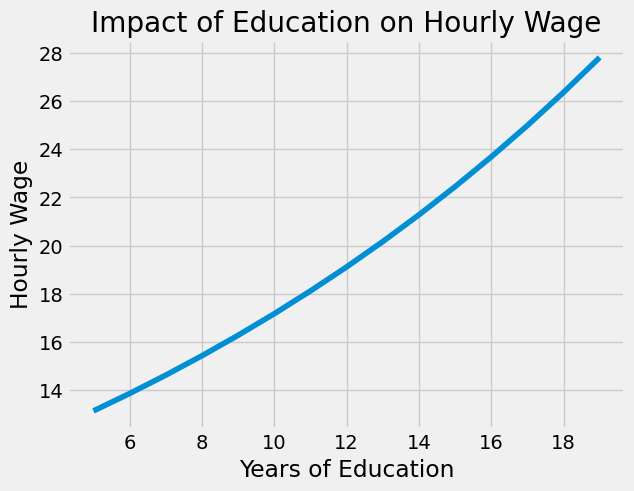

In [30]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params["Intercept"] + model_1.params["educ"] * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

Of course, it is not because we can estimate this simple model that it's correct. Notice how I was carefully with my words saying it **predicts** wage from education. I never said that this prediction was causal. In fact, by now, you probably have very serious reasons to believe this model is biased. Since our data didn't come from a random experiment, we don't know if those that got more education are comparable to those who got less. Going even further, from our understanding of how the world works, we are very certain that they are not comparable. Namely, we can argue that those with more years of education probably have richer parents, and that the increase we are seeing in wages as we increase education is just a reflection of how the family wealth is associated with more years of education. Putting it in math terms, we think that $E[Y_0|T=0] < E[Y_0|T=1]$, that is, those with more education would have higher income anyway, even without so many years of education. If you are really grim about education, you can argue that it can even *reduce* wages by keeping people out of the workforce and lowering their experience.

Fortunately, in our data, we have access to lots of other variables. We can see the parents' education `meduc`, `feduc`, the `IQ` score for that person, the number of years of experience `exper` and the tenure of the person in his or her current company `tenure`. We even have some dummy variables for marriage and black ethnicity. 

In [31]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


We can include all those extra variables in a model and estimate it:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

To understand how this helps with the bias problem, let's recap the bivariate breakdown of multivariate linear regression.

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

This formula says that we can predict `educ` from the parents' education, from IQ, from experience and so on. After we do that, we'll be left with a version of `educ`, $\tilde{educ}$, which is uncorrelated with all the variables included previously. This will break down arguments such as "people that have more years of education have it because they have higher IQ. It is not the case that education leads to higher wages. It is just the case that it is correlated with IQ, which is what drives wages". Well, if we include IQ in our model, then $\kappa$ becomes the return of an additional year of education while keeping IQ fixed. Pause a little bit to understand what this implies. Even if we can't use randomised controlled trials to keep other factors equal between treated and untreated, regression can do this by including those same factors in the model, even if the data is not random!

In [32]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

np.float64(0.04114719101005695)

This coefficient we've just estimated tells us that, for people with the same IQ, experience, tenure, age and so on, we should expect an additional year of education to be associated with a 4.11% increase in hourly wage. This confirms our suspicion that the first simple model with only `educ` was biased. It also confirms that this bias was overestimating the impact of education. Once we controlled for other factors, the estimated impact of education fell.

If we are wiser and use software that other people wrote instead of coding everything yourself, we can even place a confidence interval around this estimate. 

In [33]:
model_2 = smf.ols('lhwage ~ educ +' + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


Now, back to our question, is the parameter we've estimated for the impact of `educ` on wage causal? I'm sorry to bring it to you, but that will depend on our ability to argue in favor or against that fact that all confounders have been included in the model. Personally, I think they haven't. For instance, we haven't included family wealth. Even if we included family education, that can only be seen as a proxy for wealth. We've also not accounted for factors like personal ambition. It could be that ambition is what causes both more years of education and higher wage, so it is a confounder. This is to show that **causal inference with non-random or observational data should always be taken with a grain of salt**. We can never be sure that all confounders were accounted for.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)


## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).